![title](https://i.ibb.co/f2W87Fg/logo2020.png)

---


<table  class="tfo-notebook-buttons" align="left"><tr><td>
    
<a href="https://colab.research.google.com/github/adf-telkomuniv/CV2020_Exercises/blob/main/CV2020 - 17 - Recurrent Neural Net.ipynb" source="blank" ><img src="https://colab.research.google.com/assets/colab-badge.svg"></a>
</td><td>
<a href="https://github.com/adf-telkomuniv/CV2020_Exercises/blob/main/CV2020 - 17 - Recurrent Neural Net.ipynb" source="blank" ><img src="https://i.ibb.co/6NxqGSF/pinpng-com-github-logo-png-small.png"></a>
    
</td></tr></table>

# Task 17 - Recurrent Neural Net

In this exercise you will implement a vanilla recurrent neural networks from scratch and use them it to train a model that can generate novel captions for images.

The goals of this assignment are as follows:

* Understand the architecture of recurrent neural networks (RNNs) and how they operate on sequences by sharing weights over time
* Understand and implement Vanilla RNNs 
* Understand how to sample from an RNN language model at test-time
* Understand how to combine convolutional neural nets and recurrent nets to implement an image captioning system

Write down your Name and Student ID

In [1]:
## --- start your code here ----

NIM  = 1301170073
Nama = 'Pratama Yoga S'

## --- end your code here ----

---
---
#[Part 0] Import Libraries 
As usual, a bit of setup

In [2]:
import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import urllib.request, urllib.error, urllib.parse, os, tempfile
from imageio import imread
from PIL import Image

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

---
## 1 - Helper Functions

Below are helper functions to check your implementation

---
### a. Numerical Gradient Check

Functions to check the gradients from your implementation

a naive implementation of numerical gradient of $f$ at $x$


In [3]:
from random import randrange

def eval_numerical_gradient(f, x, verbose=True, h=0.00001):

    # evaluate function value at original point
    fx = f(x) 
    grad = np.zeros_like(x)

    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    
    while not it.finished:

        # evaluate function at x+h
        ix     = it.multi_index
        oldval = x[ix]
        x[ix]  = oldval + h # increment by h
        fxph   = f(x)       # evalute f(x + h)
        x[ix]  = oldval - h
        fxmh   = f(x)       # evaluate f(x - h)
        x[ix]  = oldval     # restore

        # compute the partial derivative with centered formula
        grad[ix] = (fxph - fxmh) / (2 * h) # the slope

        if verbose:
            print(ix, grad[ix])
        it.iternext() # step to next dimension

    return grad

---
### b. Array Gradient Check

Functions to check the array of gradients from your implementation

Evaluate a numeric gradient for a function that accepts a numpy    array and returns a numpy array.


In [4]:
def eval_numerical_gradient_array(f, x, df, h=1e-5):

    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])

    while not it.finished:

        ix = it.multi_index
        oldval = x[ix]
        x[ix]  = oldval + h
        pos    = f(x).copy()
        x[ix]  = oldval - h
        neg    = f(x).copy()
        x[ix]  = oldval

        grad[ix] = np.sum((pos - neg) * df) / (2 * h)
        it.iternext()
        
    return grad

---
### c. Relative Error Function

Function to calculate difference between your matrix and our expected results

In [5]:
def rel_error(x, y):
  
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

---
### d. Download Image Funtion

Read an image from a URL. Returns a numpy array with the pixel data.

In [6]:
def image_from_url(url):
    try:
        f = urllib.request.urlopen(url)
        _, fname = tempfile.mkstemp()
        with open(fname, 'wb') as ff:
            ff.write(f.read())

        img = imread(fname)
        # os.remove(fname)
        
        return img

    except urllib.error.URLError as e:
        print('URL Error: ', e.reason, url)
        return Image.new('RGB', (64,64), color='LightGray')
        
    except urllib.error.HTTPError as e:
        print('HTTP Error: ', e.code, url) 
        return Image.new('RGB', (64,64), color='LightGray')


---
## 2 - Install h5py
The COCO dataset we will be using is stored in HDF5 format. To load HDF5 files, we will need to install the `h5py` Python package. 

So install it if it's not already installed

In [7]:
!pip install h5py

import h5py

---
---
# [Part 1] Microsoft COCO Dataset
For this exercise we will use the $2014$ release of the [Microsoft COCO dataset](http://cocodataset.org/) which has become the standard testbed for image captioning.

The dataset consists of $80,000$ training images and $40,000$ validation images,

Each annotated with $5$ captions written by workers on **Amazon Mechanical Turk**.

---
## 1 - Download Preprocessed Data

We have preprocessed the data and extracted features for you already. For all images we have extracted features from the **fc7** layer of the **VGG-16** network pretrained on ImageNet; these features are stored in the files `train2014_vgg16_fc7.h5` and `val2014_vgg16_fc7.h5` respectively. 

To cut down on processing time and memory requirements, we have reduced the dimensionality of the features from $4096$ to $512$; these features can be found in the files `train2014_vgg16_fc7_pca.h5` and `val2014_vgg16_fc7_pca.h5`.

The raw images take up a lot of space (nearly **38GB**) so we have not included them in the download. However all images are taken from Flickr, and URLs of the training and validation images are stored in the files `train2014_urls.txt` and `val2014_urls.txt` respectively. 

This allows you to download images on the fly for visualization.

We've provided you with the implementation to download the dataset

In [8]:
!wget -O 'coco_downloader.py' 'https://github.com/adf-telkomuniv/CV2020_Exercises/raw/main/resources/coco_downloader.py' -q

Then call the `download_coco()` function below to download the Preprocessed Microsoft COCO Dataset

In [9]:
from coco_downloader import *

download_coco()

unzip the datasets, and delete the compressed one

In [10]:
!unzip -o coco_captioning.zip

!rm coco_captioning.zip

Archive:  coco_captioning.zip
   creating: coco_captioning/
  inflating: coco_captioning/coco2014_captions.h5  
  inflating: coco_captioning/coco2014_vocab.json  
  inflating: coco_captioning/train2014_images.txt  
  inflating: coco_captioning/train2014_urls.txt  
  inflating: coco_captioning/train2014_vgg16_fc7.h5  
  inflating: coco_captioning/train2014_vgg16_fc7_pca.h5  
  inflating: coco_captioning/val2014_images.txt  
  inflating: coco_captioning/val2014_urls.txt  
  inflating: coco_captioning/val2014_vgg16_fc7.h5  
  inflating: coco_captioning/val2014_vgg16_fc7_pca.h5  


---
## 2 - Text Processing

Dealing with strings is inefficient, so we will work with an encoded version of the captions.

Each word is assigned an integer ID, allowing us to represent a caption by a sequence of integers. The mapping between integer IDs and words is in the file `coco2014_vocab.json`, and you can use the function `decode_captions` to convert numpy arrays of integer IDs back into strings.

In [11]:
def decode_captions(captions, idx_to_word):
  
    singleton = False
    if captions.ndim == 1:
        singleton = True
        captions = captions[None]

    decoded = []
    N, T = captions.shape
    for i in range(N):
        words = []
        for t in range(T):
            word = idx_to_word[captions[i, t]]
            if word != '<NULL>':
                words.append(word)
            if word == '<END>':
                break
        decoded.append(' '.join(words))
    if singleton:
        decoded = decoded[0]

    return decoded

---
## 3 - Load Coco Dataset

There are a couple special tokens that we add to the vocabulary.

We prepend a special <font color='red'>**`<START>`**</font> token and append an <font color='red'>**`<END>`**</font>  token to the beginning and end of each caption respectively. Rare words are replaced with a special <font color='red'>**`<UNK>`**</font>  token (for "unknown"). 

In addition, since we want to train with minibatches containing captions of different lengths, we pad short captions with a special <font color='red'>**`<NULL>`**</font>  token after the `<END>` token and don't compute loss or gradient for `<NULL>` tokens. 

Since they are a bit of a pain, we have taken care of all implementation details around special tokens for you.

You can load all of the MS-COCO data (captions, features, URLs, and vocabulary) using the `load_coco_data` function below. Run the following cell to do so:

In [12]:
def load_coco_data(base_dir='coco_captioning', max_train=None, pca_features=True):

    data = {}
    
    # read caption encoding
    caption_file = os.path.join(base_dir, 'coco2014_captions.h5')
    with h5py.File(caption_file, 'r') as f:
        for k, v in f.items():
            data[k] = np.asarray(v)

    # use original training features or pca-reduced features
    if pca_features:
        train_feat_file = os.path.join(base_dir, 'train2014_vgg16_fc7_pca.h5')
    else:
        train_feat_file = os.path.join(base_dir, 'train2014_vgg16_fc7.h5')
    with h5py.File(train_feat_file, 'r') as f:
        data['train_features'] = np.asarray(f['features'])

    # use original validation features or pca-reduced features
    if pca_features:
        val_feat_file = os.path.join(base_dir, 'val2014_vgg16_fc7_pca.h5')
    else:
        val_feat_file = os.path.join(base_dir, 'val2014_vgg16_fc7.h5')
    with h5py.File(val_feat_file, 'r') as f:
        data['val_features'] = np.asarray(f['features'])

    # read vocabulary token
    dict_file = os.path.join(base_dir, 'coco2014_vocab.json')
    with open(dict_file, 'r') as f:
        dict_data = json.load(f)
        for k, v in dict_data.items():
            data[k] = v

    # read training image urls
    train_url_file = os.path.join(base_dir, 'train2014_urls.txt')
    with open(train_url_file, 'r') as f:
        train_urls = np.asarray([line.strip() for line in f])
    data['train_urls'] = train_urls

    # read validation image urls
    val_url_file = os.path.join(base_dir, 'val2014_urls.txt')
    with open(val_url_file, 'r') as f:
        val_urls = np.asarray([line.strip() for line in f])
    data['val_urls'] = val_urls

    # Maybe subsample the training data
    if max_train is not None:
        num_train = data['train_captions'].shape[0]
        mask = np.random.randint(num_train, size=max_train)

        data['train_captions']   = data['train_captions'][mask]
        data['train_image_idxs'] = data['train_image_idxs'][mask]

    return data


Load COCO data from disk; this returns a dictionary. We'll work with dimensionality-reduced features for this notebook, but feel free to experiment with the original features by changing the **`pca_features`** flag below.

In [13]:
data = load_coco_data(pca_features=True)

Print out all the keys and values from the data dictionary


In [14]:
p = ['  ', '', '    ','  ','  ','    ','     ','     ','      ','        ']
i=0
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k+p[i], type(v), v.shape, '\t', v.dtype)
    else:
        print(k+p[i], type(v), '\t', len(v))
    i += 1

train_captions   <class 'numpy.ndarray'> (400135, 17) 	 int32
train_image_idxs <class 'numpy.ndarray'> (400135,) 	 int32
val_captions     <class 'numpy.ndarray'> (195954, 17) 	 int32
val_image_idxs   <class 'numpy.ndarray'> (195954,) 	 int32
train_features   <class 'numpy.ndarray'> (82783, 512) 	 float32
val_features     <class 'numpy.ndarray'> (40504, 512) 	 float32
idx_to_word      <class 'list'> 	 1004
word_to_idx      <class 'dict'> 	 1004
train_urls       <class 'numpy.ndarray'> (82783,) 	 <U63
val_urls         <class 'numpy.ndarray'> (40504,) 	 <U63


---
## 4 - Look at the data
It is always a good idea to look at examples from the dataset before working with it.

You can use the `sample_coco_minibatch()` function below to sample minibatches of data from the data structure returned from `load_coco_data()`. 

In [15]:
def sample_coco_minibatch(data, batch_size=100, split='train'):
    split_size = data['%s_captions' % split].shape[0]
    mask       = np.random.choice(split_size, batch_size)

    captions       = data['%s_captions' % split][mask]
    image_idxs     = data['%s_image_idxs' % split][mask]
    image_features = data['%s_features' % split][image_idxs]
    
    urls = data['%s_urls' % split][image_idxs]
    
    return captions, image_features, urls

Run the following to sample a small minibatch of training data and show the images and their captions. 

Running it multiple times and looking at the results helps you to get a sense of the dataset.

Note that we decode the captions using the `decode_captions` function and that we download the images on-the-fly using their Flickr URL

URL Error:  Not Found http://farm3.staticflickr.com/2625/3979586948_c2f3f71ca5_z.jpg


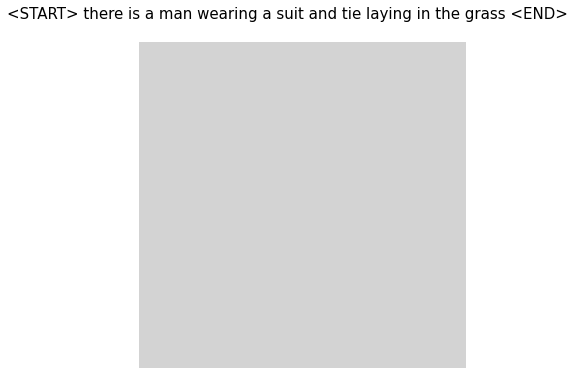


-----------------------------------------------------

URL Error:  Not Found http://farm3.staticflickr.com/2148/1781231304_de966a5b6d_z.jpg


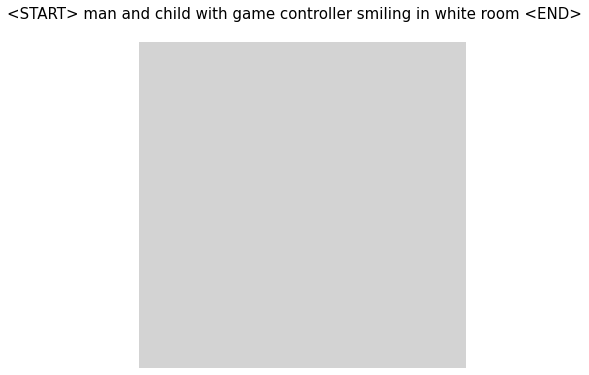


-----------------------------------------------------



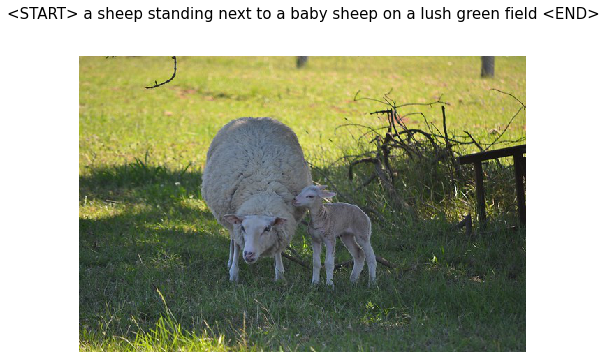


-----------------------------------------------------



In [16]:
# Sample a minibatch and show the images and captions
batch_size = 3

captions, features, urls = sample_coco_minibatch(data, batch_size=batch_size)
for i, (caption, url) in enumerate(zip(captions, urls)):
    caption_str = decode_captions(caption, data['idx_to_word'])

    fig = plt.figure(figsize=(8,6))
    fig.suptitle(caption_str, x=0, y=0.96, ha='left', size=15)

    plt.imshow(image_from_url(url))
    plt.axis('off')
    plt.show()
    
    print('\n-----------------------------------------------------\n')

Run the cell again to view another set of images

<br>

<font color='red' size=4> NOTE: </font>

You might see that some of the images are already **removed** or **lost** from the Internet. So they cannot be downloaded.

But fear not since we have already retrieved all the feature for this training

---
---
# [Part 2] Recurrent Neural Networks
As discussed in lecture, we will use Vanilla Recurrent Neural Network (RNN) language models for image captioning. 

<center> <img src='http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-SimpleRNN.png' width=600></center>

You should implement the basic layer types that are needed for Recurrent Neural Network 



---
## 1 - Single Forward Step


First implement the `rnn_step_forward()` function which implements the forward pass for a **single timestep** of a vanilla recurrent neural network that uses a tanh
    activation function. 

Store the next hidden state ($h_t$) and any values you need for the backward pass in the `next_h` and `cache` variables respectively.         
<br>

$$
\begin{align*}
xh &= x_t\cdot W_{x}\\\\
hh &= h_{t-1}\cdot W_{h}\\\\
h_t &= \tanh(hh + xh + b)\\
\end{align*}
$$  

<br>



---
#### <font color='red'>**EXERCISE:** </font>

implement the function as described above

In [17]:
def rnn_step_forward(x, prev_h, Wx, Wh, b):

    # calculate dot product from x and Wx
    xh = np.dot(x, Wx)
    
    # calculate dot product from prev_h and Wh
    hh = np.dot(prev_h, Wh)
    
    # calculate the output activation for next_h using np.tahn()
    next_h = np.tanh(xh + hh + b)

    # store intermediate value for backward pass
    cache = (x, prev_h, Wx, Wh, b, next_h)
    
    return next_h, cache


After doing so run the following to check your implementation. 
You should see errors on the order of `e-8` or less.

In [18]:
N, D, H = 3, 10, 4

x      = np.linspace(-0.4, 0.7, num=N*D).reshape(N, D)
prev_h = np.linspace(-0.2, 0.5, num=N*H).reshape(N, H)
Wx     = np.linspace(-0.1, 0.9, num=D*H).reshape(D, H)
Wh     = np.linspace(-0.3, 0.7, num=H*H).reshape(H, H)
b      = np.linspace(-0.2, 0.4, num=H)

next_h, _ = rnn_step_forward(x, prev_h, Wx, Wh, b)

expected_next_h = np.asarray([
  [-0.58172089, -0.50182032, -0.41232771, -0.31410098],
  [ 0.66854692,  0.79562378,  0.87755553,  0.92795967],
  [ 0.97934501,  0.99144213,  0.99646691,  0.99854353]])

print('next_h error: ', rel_error(expected_next_h, next_h))

next_h error:  6.292421426471037e-09


**EXPECTED OUTPUT**:
<pre>
    next_h error:  6.292421426471037e-09

---
## 2 - Single Backward Step

Next, implement the backward pass for a single step of a vanilla RNN in `rnn_step_backward()` function below.

For the tanh function, you can compute the local derivative in terms of the output value from tanh. 

<br>

$$ \partial\tanh(x) = 1-\tanh^2(x) $$

<br>



---
with 
<table>
  <tr>
    <td><font size=3>$\partial h_t$</font></td>
    <td>:</td>
    <td><font size=3><pre>dh</pre></font></td>
    <td>|<br>|<br>|<br>|</td>
    <td><font size=3>$h_{t+1}$</font></td>
    <td>:</td>
    <td><font size=3><pre>next_h</pre></font></td>
    <td>|<br>|<br>|<br>|</td>
    <td><font size=3>$\partial h_{t+1}$</font></td>
    <td>:</td>
    <td><font size=3><pre>dnext_h</pre></font></td> 
    <td>|<br>|<br>|<br>|</td>
    <td><font size=3>$\partial h_{t-1}$</font></td>
    <td>:</td>
    <td><font size=3><pre>dprev_h</pre></font></td>
    <td>|<br>|<br>|<br>|</td>
    <td><font size=3>$h_{t-1}$</font></td>
    <td>:</td>
    <td><font size=3><pre>prev_h</pre></font></td>
  </tr>
</table>

<br>

The complete derivative of bacward RNN step is as below:

<br>

$$
\begin{align*}
\partial h_t &= (1-(h_{t+1})^2) * \partial h_{t+1} &|& & \partial W_x &= x^T\cdot \partial h_t\\\\
\partial x &= \partial h_t \cdot (W_x)^T &|& & \partial W_h &= (h_{t-1})^T\cdot \partial h_t\\\\
\partial h_{t-1} &= \partial h_t \cdot (W_h)^T &|& & \partial b &= \sum(\partial h_t)
\end{align*}
$$

---
#### <font color='red'>**EXERCISE:** </font>

implement the function as described above

In [33]:
def rnn_step_backward(dnext_h, cache):

    # extract intermediate cache
    x, prev_h, Wx, Wh, b, next_h = cache

    # calculate local gradient of hiddent state, 
    # which is local gradient of tanh (1-next_h^2)
    # multiplied by the upstream gradient dnext_h,
    # as stated above,
    dh = (1-(next_h**2)) * dnext_h
  
    # calculate gradient of x,
    # which is a dot product of dh with transpose of Wx
    dx = np.dot(dh, Wx.T)
    
    # calculate gradient of previous hidden state, 
    # which is a dot product of dh with transpose of Wh
    dprev_h = np.dot(dh, Wh.T)
    
    # calculate gradient of Wx, 
    # which is a dot product of x transpose with dh
    dWx = np.dot(x.T, dh)
    
    # calculate gradient of Wh, 
    # which is a dot product of transposed previous hidden state with dh
    dWh = np.dot(prev_h.T, dh)
    
    # calculate gradient of bias, 
    # which is a sum of dh over axis=0
    db = np.sum(dh, axis=0)

    return dx, dprev_h, dWx, dWh, db

After doing so run the following to numerically gradient check your implementation. 

You should see errors on the order of `e-8` or less.

In [34]:
np.random.seed(231)
N, D, H = 4, 5, 6

x  = np.random.randn(N, D)
h  = np.random.randn(N, H)
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b  = np.random.randn(H)

out, cache = rnn_step_forward(x, h, Wx, Wh, b)


In [35]:
dnext_h = np.random.randn(*out.shape)

fx  = lambda x:  rnn_step_forward(x, h, Wx, Wh, b)[0]
fh  = lambda prev_h: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_step_forward(x, h, Wx, Wh, b)[0]
fb  = lambda b:  rnn_step_forward(x, h, Wx, Wh, b)[0]

dx_num      = eval_numerical_gradient_array(fx,  x,  dnext_h)
dprev_h_num = eval_numerical_gradient_array(fh,  h,  dnext_h)
dWx_num     = eval_numerical_gradient_array(fWx, Wx, dnext_h)
dWh_num     = eval_numerical_gradient_array(fWh, Wh, dnext_h)
db_num      = eval_numerical_gradient_array(fb,  b,  dnext_h)

dx, dprev_h, dWx, dWh, db = rnn_step_backward(dnext_h, cache)

print('dx error      : ', rel_error(dx_num, dx))
print('dprev_h error : ', rel_error(dprev_h_num, dprev_h))
print('dWx error     : ', rel_error(dWx_num, dWx))
print('dWh error     : ', rel_error(dWh_num, dWh))
print('db error      : ', rel_error(db_num, db))

dx error      :  4.0192769090159184e-10
dprev_h error :  2.5632975303201374e-10
dWx error     :  8.820222259148609e-10
dWh error     :  4.703287554560559e-10
db error      :  7.30162216654e-11


**EXPECTED OUTPUT**:

<pre>
    dx error      :  4.0192769090159184e-10
    dprev_h error :  2.5632975303201374e-10
    dWx error     :  8.820222259148609e-10
    dWh error     :  4.703287554560559e-10
    db error      :  7.30162216654e-11

---
## 3 - Forward Pass
Now that you have implemented the forward and backward passes for a single timestep of a vanilla RNN, you will combine these pieces to implement a RNN that processes an entire sequence of data.


* We assume an input sequence composed of $T$ vectors, each of dimension $D$.

* The RNN uses a hidden size of $H$, and we work over a minibatch containing $N$ sequences.

After running the RNN forward, we return the hidden states for all timesteps.


---
#### <font color='red'>**EXERCISE:** </font>
Implement forward pass for a vanilla RNN running on a sequence of input data. 


In [37]:
def rnn_forward(x, h0, Wx, Wh, b):

    # get the size of N, T, H, and D
    N, T, D = x.shape
    N, H    = h0.shape
    
    # create a zeros matrix in shape of (N, T, H)
    # to store the hidden activation
    h = np.zeros((N,T,H))
    
    # set h0 as the previous hidden activation 
    prev_h = h0
    
    #initialize cache dictionary
    cache = {}

    # start RNN forward 
    # loop over the timestep
    for i in range(T):
        
        # select x at timestep i 
        xt = x[:, i, :]
        
        # call rnn_step_forward() function with input xt, prev_h, 
        # and its weights Wx, Wh, and b
        current_h, cache_i = rnn_step_forward(xt, prev_h, Wx, Wh, b)
        
        # store the current hidden activation to the i-th timestep in matrix h
        h[:, i, :] = current_h        
        
        # store the cache_i result to cache dictionary
        cache[i] = cache_i
        
        # for the next iteration, set current hidden activation as previous activation
        prev_h = current_h

    return h, cache

After doing so run the following to check your implementation. You should see errors on the order of `e-7` or less.

In [38]:
N, T, D, H = 2, 3, 4, 5

x  = np.linspace(-0.1, 0.3, num=N*T*D).reshape(N, T, D)
h0 = np.linspace(-0.3, 0.1, num=N*H).reshape(N, H)
Wx = np.linspace(-0.2, 0.4, num=D*H).reshape(D, H)
Wh = np.linspace(-0.4, 0.1, num=H*H).reshape(H, H)
b  = np.linspace(-0.7, 0.1, num=H)

h, _ = rnn_forward(x, h0, Wx, Wh, b)


expected_h = np.asarray([
  [[-0.42070749, -0.27279261, -0.11074945,  0.05740409,  0.22236251],
    [-0.39525808, -0.22554661, -0.0409454,   0.14649412,  0.32397316],
    [-0.42305111, -0.24223728, -0.04287027,  0.15997045,  0.35014525]],
  [[-0.55857474, -0.39065825, -0.19198182,  0.02378408,  0.23735671],
    [-0.27150199, -0.07088804,  0.13562939,  0.33099728,  0.50158768],
    [-0.51014825, -0.30524429, -0.06755202,  0.17806392,  0.40333043]]
  ])

print('h error: ', rel_error(expected_h, h))

h error:  7.728466158305164e-08


**EXPECTED OUTPUT**:
<pre>
    h error:  7.728466151011529e-08

---
## 4 - Backward Pass

Implement the backward pass for a vanilla RNN running an entire sequence of data in the function `rnn_backward`. 

This should run back-propagation over the entire sequence, making calls to the `rnn_step_backward` function that you defined earlier. 

<br>


**NOTE** that `dh` contains the upstream gradients produced by the individual loss functions at each timestep,
and ***NOT*** the gradients being passed between timesteps <br>(which you'll have to compute yourself by calling `rnn_step_backward` in a loop).


---
#### <font color='red'>**EXERCISE:** </font>
Implement backward pass for a vanilla RNN running on a sequence of input data. 


In [60]:
def rnn_backward(dh, cache):
    
    # get the x data and D dimension
    x = cache[0][0]
    D = x.shape[1]
    
    # get the size of N, T, and H
    N, T, H = dh.shape
    
    # initialize zeros matrix with the appropriate size
    dx  = np.zeros((N,T,D)) # shaped (N, T, D)
    dh0 = np.zeros((N,H)) # shaped (N, H)
    dWx = np.zeros((D,H)) # shaped (D, H)
    dWh = np.zeros((H,H)) # shaped (H, H)
    db  = np.zeros(H) # shaped (H)

    # initialzie zeros matrix for the current gradient h for the loop
    # same size as dh0
    dprev_h = dh0.copy()

    # backward loop over timestep
    for i in reversed(range(T)):
        
        # select dh at timestep i
        dht = dh[:, i, :]
        
        # gradient of next_h is the sum of dht and dprev_h
        dnext_h = dht + dprev_h
        
        # get i-th cache from cache dictionary
        cache_i = cache[i]

        # call rnn_step_backward() with input dnext_h and cache_i
        dx[:, i, :], dprev_h, dWx_t, dWh_t, db_t = rnn_step_backward(dnext_h, cache_i)

        # accumulate the Wx gradient over loop into dWx
        dWx = dWx + dWx_t
        
        # accumulate the Wh gradient over loop into dWh
        dWh += dWh_t
        
        # accumulate the bias gradient over loop into db
        db += db_t

    # store the last gradient of hidden state as dh0
    dh0 = dprev_h

    return dx, dh0, dWx, dWh, db

Test your implementation. You should see errors on the order of `e-6` or less.

In [61]:
np.random.seed(231)

N, D, T, H = 2, 3, 10, 5

x  = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b  = np.random.randn(H)

out, cache = rnn_forward(x, h0, Wx, Wh, b)


In [62]:
dout = np.random.randn(*out.shape)

dx, dh0, dWx, dWh, db = rnn_backward(dout, cache)

fx  = lambda x: rnn_forward(x, h0, Wx, Wh, b)[0]
fh0 = lambda h0: rnn_forward(x, h0, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_forward(x, h0, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_forward(x, h0, Wx, Wh, b)[0]
fb  = lambda b: rnn_forward(x, h0, Wx, Wh, b)[0]

dx_num  = eval_numerical_gradient_array(fx, x, dout)
dh0_num = eval_numerical_gradient_array(fh0, h0, dout)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dout)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dout)
db_num  = eval_numerical_gradient_array(fb, b, dout)

print('dx error  : ', rel_error(dx_num, dx))
print('dh0 error : ', rel_error(dh0_num, dh0))
print('dWx error : ', rel_error(dWx_num, dWx))
print('dWh error : ', rel_error(dWh_num, dWh))
print('db error  : ', rel_error(db_num, db))

dx error  :  1.5382468491701097e-09
dh0 error :  3.3839681556240896e-09
dWx error :  7.150535245339328e-09
dWh error :  1.297338408201546e-07
db error  :  1.4889022954777414e-10



**EXPECTED OUTPUT**:

<pre>
    dx error  :  1.5382468491701097e-09
    dh0 error :  3.3839681556240896e-09
    dWx error :  7.150535245339328e-09
    dWh error :  1.297338408201546e-07
    db error  :  1.4889022954777414e-10


---
---
# [Part 3] Temporal Affine Layer
At every timestep we use an affine function to transform the RNN hidden vector at that timestep into scores for each word in the vocabulary. 

This is very similar to the affine layer that you implemented in previous assignmens, so complete the `temporal_affine_forward` and `temporal_affine_backward` functions below. 

---
## 1 - Forward Pass
Forward pass for a temporal affine layer. 

The input is a set of $D$-dimensional     vectors arranged into a minibatch of $N$ timeseries, each of length $T$. 

We use     an affine function to transform each of those vectors into a new vector of     dimension $M$.

---
#### <font color='red'>**EXERCISE:** </font>

implement the function as described above

In [63]:
def temporal_affine_forward(x, w, b):

    # get the size of N, T, and D
    N, T, D = x.shape

    # get the size of M
    M = b.shape[0]

    # reshape x into shape (N*T, D)
    x_reshape = x.reshape((N*T, D))

    # output = dot product x_reshape with w
    out = np.dot(x_reshape, w)
    
    # reshape output into shape (N, T, M)
    out = out.reshape((N, T, M))
    
    # add bias b to output
    out += b

    # store cache for backward pass
    cache = x, w, b, out

    return out, cache

---
## 2 - Backward Pass Pass

Backward pass for a temporal affine layer. 

Again, it's very much alike normal affine layer, but with temporal input shape

Thus you need to reshape the matrix to the appropriate shape before calculating dot product


---
#### <font color='red'>**EXERCISE:** </font>

implement the function as described above

In [64]:
def temporal_affine_backward(dout, cache):
  
    # extract cache
    x, w, b, out = cache

    # get the size of N, T, and D
    N, T, D = x.shape

    # get the size of M
    M = b.shape[0]

    # reshape dout into shape (N*T, M)
    dout_reshape = dout.reshape((N*T, M))

    # reshape x into shape (N*T, D)
    x_reshape = x.reshape((N*T, D))

    # dx = dot product dout_reshape with w.transpose
    dx = np.dot(dout_reshape, w.T)
    
    # reshape dx back into shape (N, T, D)
    dx = dx.reshape((N, T, D))
    
    # dw = dot product dout_reshape.transpose with x_reshape
    dw = np.dot(dout_reshape.T, x_reshape)

    # transpose back dw
    dw = dw.T

    # sum dout over axis=(0,1)
    db = dout.sum(axis=(0, 1))

    return dx, dw, db

Run the following to perform numeric gradient checking on the implementation. You should see errors on the order of `e-9` or less.

In [65]:
np.random.seed(231)

# Gradient check for temporal affine layer
N, T, D, M = 2, 3, 4, 5
x = np.random.randn(N, T, D)
w = np.random.randn(D, M)
b = np.random.randn(M)

out, cache = temporal_affine_forward(x, w, b)

In [66]:
dout = np.random.randn(*out.shape)

fx = lambda x: temporal_affine_forward(x, w, b)[0]
fw = lambda w: temporal_affine_forward(x, w, b)[0]
fb = lambda b: temporal_affine_forward(x, w, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dw_num = eval_numerical_gradient_array(fw, w, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

dx, dw, db = temporal_affine_backward(dout, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

dx error:  2.9215945034030545e-10
dw error:  1.5772088618663602e-10
db error:  3.252200556967514e-11


**EXPECTED OUTPUT**:
<pre>
    dx error:  2.9215945034030545e-10
    dw error:  1.5772088618663602e-10
    db error:  3.252200556967514e-11

---
## 3 - Temporal Softmax loss
In an RNN language model, at every timestep we produce a score for each word in the vocabulary. We know the ground-truth word at each timestep, so we use a softmax loss function to compute loss and gradient at each timestep. We sum the losses over time and average them over the minibatch.

However there is one wrinkle: since we operate over minibatches and different captions may have different lengths, we append `<NULL>` tokens to the end of each caption so they all have the same length. We don't want these `<NULL>` tokens to count toward the loss or gradient, so in addition to scores and ground-truth labels our loss function also accepts a `mask` array that tells it which elements of the scores count towards the loss.

Since this is very similar to the softmax loss function you implemented in previous assignment, we have implemented this loss function for you; look at the `temporal_softmax_loss` function below.

We assume that we are     making predictions over a vocabulary of size $V$ for each timestep of a    timeseries of length $T$, over a minibatch of size $N$. 

The input $x$ gives scores    for all vocabulary elements at all timesteps, and $y$ gives the indices of the    ground-truth element at each timestep. 

We use a cross-entropy loss at each    timestep, summing the loss over all timesteps and averaging across the    minibatch.

As an additional complication, we may want to ignore the model output at some
timesteps, since sequences of different length may have been combined into a
minibatch and padded with NULL tokens. The optional mask argument tells us
which elements should contribute to the loss.


In [67]:
def temporal_softmax_loss(x, y, mask, verbose=False):

    N, T, V = x.shape

    x_flat = x.reshape(N * T, V)
    y_flat = y.reshape(N * T)
    
    mask_flat = mask.reshape(N * T)

    probs  = np.exp(x_flat - np.max(x_flat, axis=1, keepdims=True))
    probs /= np.sum(probs, axis=1, keepdims=True)
    loss   = -np.sum(mask_flat * np.log(probs[np.arange(N * T), y_flat])) / N

    dx_flat = probs.copy()
    dx_flat[np.arange(N * T), y_flat] -= 1
    dx_flat /= N
    dx_flat *= mask_flat[:, None]

    if verbose: print('dx_flat: ', dx_flat.shape)

    dx = dx_flat.reshape(N, T, V)

    return loss, dx

Run the following cell to sanity check the loss and perform numeric gradient checking on the function. You should see an error for dx on the order of `e-7` or less.

In [68]:
N, T, V = 100, 1, 10

def check_loss(N, T, V, p):
    x = 0.001 * np.random.randn(N, T, V)
    y = np.random.randint(V, size=(N, T))
    mask = np.random.rand(N, T) <= p
    print(temporal_softmax_loss(x, y, mask)[0])

check_loss(100, 1, 10, 1.0)   # Should be about 2.3
check_loss(100, 10, 10, 1.0)  # Should be about 23
check_loss(5000, 10, 10, 0.1) # Should be about 2.3

2.3027781774290146
23.025985953127226
2.2643611790293394


**EXPECTED OUTPUT**:
<pre>
    2.3027781774290146  (Should be about 2.3)
    23.025985953127226  (Should be about 23) 
    2.2643611790293394  (Should be about 2.3)

Gradient check for temporal softmax loss

In [69]:
N, T, V = 7, 8, 9

x = np.random.randn(N, T, V)
y = np.random.randint(V, size=(N, T))
mask = (np.random.rand(N, T) > 0.5)

loss, dx = temporal_softmax_loss(x, y, mask, verbose=False)

dx_num = eval_numerical_gradient(lambda x: temporal_softmax_loss(x, y, mask)[0], x, verbose=False)

print('dx error: ', rel_error(dx, dx_num))

dx error:  2.583585303524283e-08


**EXPECTED OUTPUT**:
<pre>
    dx error:  2.583585303524283e-08


---
---
# [Part 4] Helper Functions

To further implement the image captioning process, we need several other funtions, such as Affine Layer functions and Optimizer functions. Which you have already made before.

Thus for the rest of the function, we've provided you with the implementation

But let's walk through each of them

---
## 1 - Word Embedding
In deep learning systems, we commonly represent words using vectors. 

Each word of the vocabulary will be associated with a vector, and these vectors will be learned jointly with the rest of the system.

Below we've provided you with the simple implementation of Forward and Backward pass of Word Embedding

---
### a. Forward Pass

Function `word_embedding_forward` below is the implementation of the forward pass for word embeddings. 

The function will convert words (represented by integers) into vectors. 

* operate on minibatches of size $N$ where    each sequence has length $T$.

* assume a vocabulary of $V$ words, assigning each    word to a vector of dimension $D$.


In [70]:
def word_embedding_forward(x, W):
    
    out   = W[x, :]
    cache = x, W

    return out, cache

---
### b. Backward Pass
Function `word_embedding_backward` below is the implementation of the backward pass for the word embedding.

We cannot back-propagate into the words     since they are integers, so we only return gradient for the word embedding     matrix.

In [71]:
def word_embedding_backward(dout, cache):

    x, W = cache
    dW   = np.zeros_like(W)
    np.add.at(dW, x, dout)

    return dW

---
## 2 - Affine Functions

Affine implementation as you have implemented in previous assignments

---
### a. Forward Pass

Computes the forward pass for an affine (fully-connected) layer.

The input $x$ has shape $(N, d_1, ..., d_k)$ where $x[i]$ is the $i^{th}$ input.

We multiply this against a weight matrix of shape $(D, M)$ 

In [72]:
def affine_forward(x, w, b):
  
    out = x.reshape(x.shape[0], -1).dot(w) + b
    cache = (x, w, b)

    return out, cache

---
### b. Backward Pass

Computes the backward pass for an affine layer.

In [73]:
def affine_backward(dout, cache):

    x, w, b = cache

    dx = dout.dot(w.T).reshape(x.shape)
    dw = x.reshape(x.shape[0], -1).T.dot(dout)
    db = np.sum(dout, axis=0)
    
    return dx, dw, db

---
## 3 - Optimizer Functions

Here we also provide you with `SGD` and `Adam` optimization function

---
### a. SGD Optimizer
 Performs vanilla stochastic gradient descent.


In [74]:
def sgd(w, dw, config=None):

    if config is None: config = {}
    config.setdefault('learning_rate', 1e-2)

    w -= config['learning_rate'] * dw

    return w, config

---
### b. Adam Optimizer
Uses the Adam update rule, which incorporates moving averages of both the     gradient and its square and a bias correction term.


In [75]:
def adam(x, dx, config=None):

    if config is None: config = {}
    config.setdefault('learning_rate', 1e-3)
    config.setdefault('beta1', 0.9)
    config.setdefault('beta2', 0.999)
    config.setdefault('epsilon', 1e-8)
    config.setdefault('m', np.zeros_like(x))
    config.setdefault('v', np.zeros_like(x))
    config.setdefault('t', 0)

    next_x = None
    beta1, beta2, eps = config['beta1'], config['beta2'], config['epsilon']
    t, m, v = config['t'], config['m'], config['v']

    m = beta1 * m + (1 - beta1) * dx
    v = beta2 * v + (1 - beta2) * (dx * dx)
    t += 1

    alpha = config['learning_rate'] * np.sqrt(1 - beta2 ** t) / (1 - beta1 ** t)

    x -= alpha * (m / (np.sqrt(v) + eps))

    config['t'] = t
    config['m'] = m
    config['v'] = v

    next_x = x

    return next_x, config

---
---
# [Part 5] RNN for image captioning
Now that you have implemented the necessary layers, you can combine them to build an image captioning model. 


Implement the forward and backward pass of the model in the `loss` function. 

For now you only need to implement the case where `cell_type='rnn'` for vanialla RNNs; you will implement the LSTM case later. 

After doing so, run the following to check your forward pass using a small test case; you should see error on the order of `e-10` or less.

---
## 1 - Weights Initialization Function

Below is the function we've provided to initialize weights of the RNN

In [76]:
def init_weights(word_to_idx, input_dim=512, wordvec_dim=128, hidden_dim=128, dtype=np.float32):
    
    vocab_size = len(word_to_idx)
    idx_to_word = {i: w for w, i in word_to_idx.items()}
    weights = {}

    # Initialize word vectors
    # Word embedding matrix
    weights['W_embed'] = np.random.randn(vocab_size, wordvec_dim)
    weights['W_embed'] /= 100

    # Initialize CNN -> hidden state projection parameters    
    # Weight and bias for the affine transform from image features to initial
    # hidden state
    weights['W_proj'] = np.random.randn(input_dim, hidden_dim)
    weights['W_proj'] /= np.sqrt(input_dim)
    weights['b_proj'] = np.zeros(hidden_dim)

    # Initialize parameters for the RNN
    # Input-to-hidden, hidden-to-hidden, and biases for the RNN
    # dim_mul = {'lstm': 4, 'rnn': 1}
    dim_mul = 1
    weights['Wx'] = np.random.randn(wordvec_dim, dim_mul * hidden_dim)
    weights['Wx'] /= np.sqrt(wordvec_dim)
    weights['Wh'] = np.random.randn(hidden_dim, dim_mul * hidden_dim)
    weights['Wh'] /= np.sqrt(hidden_dim)
    weights['b'] = np.zeros(dim_mul * hidden_dim)

    # Initialize output to vocab weights
    # Weight and bias for the hidden-to-vocab transformation.
    weights['W_vocab'] = np.random.randn(hidden_dim, vocab_size)
    weights['W_vocab'] /= np.sqrt(hidden_dim)
    weights['b_vocab'] = np.zeros(vocab_size)

    # Cast parameters to correct dtype
    for k, v in weights.items():
        weights[k] = v.astype(dtype)

    return weights

---
## 2 - Captioning Step


Implement the forward and backward passes for the RNN Model.

In the forward pass you will need to do the following:                   
* Use an affine transformation to compute the initial hidden state from the image features. This should produce an array of shape (N, H)

* Use a word embedding layer to transform the words in captions_in from indices to vectors, giving an array of shape (N, T, W).         
* Use a vanilla RNN to process the sequence of input word vectors and produce hidden state vectors for all timesteps, producing an array of shape (N, T, H).
* Use a (temporal) affine transformation to compute scores over the vocabulary at every timestep using the hidden states, giving an array of shape (N, T, V).                                            
* Use (temporal) softmax to compute loss using captions_out, ignoring the points where the output word is <NULL> using the mask defined.     
                                                                         
In the backward pass you will need to compute the gradient of the loss with respect to all model parameters.
* `grads[k]` should give the gradients for `weights[k]`.

---
#### <font color='red'>**EXERCISE:** </font>

implement the function as described above

In [86]:
def rnn_step(weights, features, captions, word_to_idx):
    
    # create special token
    token_null  = word_to_idx['<NULL>']
    token_start = word_to_idx.get('<START>', None)
    token_end   = word_to_idx.get('<END>', None)


    # Cut captions into two pieces: 
    #   captions_in has everything but the last word and will be input to the RNN; 
    #   captions_out has everything but the first word and this is what we will expect the RNN to generate. 

    # These are offset by one relative to each other because the RNN should produce word (t+1)
    # after receiving word t. 

    # The first element of captions_in will be the START token, 
    # and the first element of captions_out will be the first word.
    captions_in  = captions[:, :-1]
    captions_out = captions[:, 1:]

    # mask to calculate temporal softmax loss
    mask = (captions_out != token_null)

    # Weight and bias for the affine transform from image features to initial
    # hidden state
    W_proj, b_proj = weights['W_proj'], weights['b_proj']

    # Word embedding matrix
    W_embed = weights['W_embed']

    # Input-to-hidden, hidden-to-hidden, and biases for the RNN
    Wx, Wh, b = weights['Wx'], weights['Wh'], weights['b']

    # Weight and bias for the hidden-to-vocab transformation.
    W_vocab, b_vocab = weights['W_vocab'], weights['b_vocab']
    
    # initialize gradients dictionary
    grads = {}
    
    ############################################################################
    # TODO: Implement the forward and backward passes for the CaptioningRNN.   #
    ############################################################################
    
    # ------------------------------------------------
    # Forward Pass
    # ------------------------------------------------
    
    # (1) project the input image feature into hidden vector
    # call affine_forward() function with input features, with W_proj and b_proj as the projection weights
    hidden_init, cache_init = affine_forward(features, W_proj, b_proj)

    # (2) convert the caption of image batch into word embedding
    # call word_embedding_forward() function with input caption_in and W_embed weight
    captions_in_init, cache_embed = word_embedding_forward(captions_in, W_embed)

    # (3) RNN Forward Pass
    # call rnn_forward() function with input captions_in_init and hidden_init
    # also pass the weights Wx, Wh, and bias b weights into the function
    hidden_rnn, cache_rnn = rnn_forward(captions_in_init, hidden_init, Wx, Wh, b)
    
    # (4) calculate temporal scores
    # call temporal_affine_forward() function with input hidden_rnn also W_vocab and b_vocab
    scores, cache_scores = temporal_affine_forward(hidden_rnn, W_vocab, b_vocab)
        
    # ------------------------------------------------
    # Calculate Temporal Softmax Loss
    # ------------------------------------------------
    # call temporal_softmax_loss() function with input scores, caption_out, and mask that was defined above
    loss, dscores = temporal_softmax_loss(scores, captions_out, mask)

   
    # ------------------------------------------------
    # Backward Pass
    # ------------------------------------------------   
        
    # (4) backward pass temporal affine
    # call temporal_affine_backward() function with input dscores and its appropriate cache (see the forward pass)
    dhidden_rnn, grads['W_vocab'], grads['b_vocab'] = temporal_affine_backward(dscores, cache_scores)

    # (3) RNN Backward Pass
    # call rnn_backward() function with input dhidden_rnn and its appropriate cache (see the forward pass)
    dcaptions_in_init, dhidden_init, grads['Wx'], grads['Wh'], grads['b'] = rnn_backward(dhidden_rnn, cache_rnn)


    # (2) backward pass embedding
    # call word_embedding_backward() function with input dcaption_in_init and its appropriate cache (see the forward pass)
    grads['W_embed'] = word_embedding_backward(dcaptions_in_init, cache_embed)

    # (1) backward pass affine
    # call affine_backward() function with input dhidden_init and its appropriate cache (see the forward pass)
    dfeatures, grads['W_proj'], grads['b_proj'] = affine_backward(dhidden_init, cache_init)
    
    
    return loss, grads

After doing so, run the following to check your forward pass using a small test case; 

you should see error on the order of `e-10` or less.

In [87]:
N, D, W, H = 10, 20, 30, 40

word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 13

model = init_weights(word_to_idx, input_dim=D, wordvec_dim=W, hidden_dim=H, dtype=np.float64)

In [88]:
# Set all model parameters to fixed values
for k, v in model.items():
    model[k] = np.linspace(-1.4, 1.3, num=v.size).reshape(*v.shape)

features = np.linspace(-1.5, 0.3, num=(N * D)).reshape(N, D)
captions = (np.arange(N * T) % V).reshape(N, T)

loss, grads   = rnn_step(model, features, captions, word_to_idx)
expected_loss = 9.83235591003

print('loss          : ', loss)
print('expected loss : ', expected_loss)
print('difference    : ', abs(loss - expected_loss))

loss          :  9.832355910027387
expected loss :  9.83235591003
difference    :  2.6130209107577684e-12


**EXPECTED OUTPUT**:
<pre>
    loss          :  9.832355910027387
    expected loss :  9.83235591003
    difference    :  2.6130209107577684e-12

Run the following cell to perform numeric gradient checking; you should see errors around the order of `e-6` or less.

In [89]:
np.random.seed(231)

batch_size  = 2
timesteps   = 3
input_dim   = 4
wordvec_dim = 5
hidden_dim  = 6
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
vocab_size  = len(word_to_idx)

captions = np.random.randint(vocab_size, size=(batch_size, timesteps))
features = np.random.randn(batch_size, input_dim)

model = init_weights(word_to_idx, input_dim=input_dim, wordvec_dim=wordvec_dim, hidden_dim=hidden_dim, dtype=np.float64)

loss, grads = rnn_step(model, features, captions, word_to_idx)

prettyfy = ['',' ', '', '     ', '     ', '      ', ' ', '']
i=0
for param_name in sorted(grads):
    f = lambda _: rnn_step(model, features, captions, word_to_idx)[0]
    param_grad_num = eval_numerical_gradient(f, model[param_name], verbose=False, h=1e-6)
    
    e = rel_error(param_grad_num, grads[param_name])

    print('%s relative error  %s : %e' % (param_name, prettyfy[i], e))
    i+=1

W_embed relative error   : 2.331070e-09
W_proj relative error    : 1.112417e-08
W_vocab relative error   : 4.274379e-09
Wh relative error        : 5.858117e-09
Wx relative error        : 1.590657e-06
b relative error         : 9.727211e-10
b_proj relative error    : 1.934807e-08
b_vocab relative error   : 7.087097e-11


**EXPECTED OUTPUT**:
<pre>
    W_embed relative error   : 2.331070e-09
    W_proj relative error    : 1.112417e-08
    W_vocab relative error   : 4.274379e-09
    Wh relative error        : 5.858117e-09
    Wx relative error        : 1.590657e-06
    b relative error         : 9.727211e-10
    b_proj relative error    : 1.934807e-08
    b_vocab relative error   : 7.087097e-11

---
## 3 - Training Function

Similar to the training function that we used to train image classification models on the previous assignment.

Here we also provide you the training function for the RNN Captioning. 

Read through the `rnn_captioning_train()` function below; it should look very familiar.

<br>

On each epoch it will:
1. batch the training input 

2. call `rnn_step` function to perform forward and backward pass and calculate the gradient
3. perform weight update using the optimization function passed in `optimizer`

In [90]:
def rnn_captioning_train(weights, data, word_to_idx, 
                         optimizer = sgd, optim_config={},
                         epochs=10, batch_size=100, lr_decay=1.0, 
                         print_every=10, verbose=1):

    best_val_acc = 0
    best_params  = {}

    loss_history      = []
    train_acc_history = []
    val_acc_history   = []
    
    # Make a deep copy of the optim_config for each parameter
    optim_configs = {}
    for p in weights:
        d = {k: v for k, v in optim_config.items()}
        optim_configs[p] = d

    num_train = data['train_captions'].shape[0]

    # total iteration per epoch
    num_iter  = max(num_train // batch_size, 1)
    
    #start iteration counts
    it = 0

    # Start Train
    for ep in range(epochs):    

        # loop over batch iteration
        for i in range(num_iter):
        
            # ------------------------------------------------
            # 1. Sample Minibatch of Training Data
            # ------------------------------------------------
            captions, features, urls = sample_coco_minibatch(data, 
                                                             batch_size=batch_size, 
                                                             split='train')

            # ------------------------------------------------
            # 2. Compute loss and gradient
            # ------------------------------------------------
            loss, grads = rnn_step(weights, features, captions, word_to_idx)
            loss_history.append(loss)


            # ------------------------------------------------
            # 3. Parameter Update
            # ------------------------------------------------   
            # Perform a parameter update
            for p, w in weights.items():
                dw     = grads[p]
                config = optim_configs[p]

                next_w, next_config = optimizer(w, dw, config)
                weights[p]          = next_w
                optim_configs[p]    = next_config
            
            # iteration count
            it +=1

            # Maybe print training loss
            if verbose==1 and it % print_every == 0:
                print ('iteration',it,'(epoch', ep,'/',epochs, '): loss =', loss_history[-1])

        # At the end of one epoch:
        # Decay learning rate        
        for k in optim_configs:
            optim_configs[k]['learning_rate'] *= lr_decay


    print('Training Done')
    return loss_history, weights

---
## 4 - Overfit small data

Once you have familiarized yourself with the function, run the following to make sure your model overfits a small sample of 100 training examples. You should see a final loss of less than 0.1.

First, initialize the model

In [91]:
np.random.seed(231)

small_data = load_coco_data(max_train=50)

small_rnn_model = init_weights(
    word_to_idx = data['word_to_idx'], 
    input_dim   = data['train_features'].shape[1],
    wordvec_dim = 256, 
    hidden_dim  = 512,
)

Overfit small data

In [92]:
loss_history, small_rnn_model = rnn_captioning_train(
    small_rnn_model,
    data         = small_data, 
    word_to_idx  = data['word_to_idx'], 
    optimizer    = adam, 
    optim_config = {'learning_rate': 5e-3,},
    epochs       = 100,
    batch_size   = 64,
)

iteration 10 (epoch 9 / 100 ): loss = 10.39589842171457
iteration 20 (epoch 19 / 100 ): loss = 0.5411451474049034
iteration 30 (epoch 29 / 100 ): loss = 0.0648023488953653
iteration 40 (epoch 39 / 100 ): loss = 0.023956347878327976
iteration 50 (epoch 49 / 100 ): loss = 0.014212462476073995
iteration 60 (epoch 59 / 100 ): loss = 0.01028787895456174
iteration 70 (epoch 69 / 100 ): loss = 0.007781723609767952
iteration 80 (epoch 79 / 100 ): loss = 0.006618188745883576
iteration 90 (epoch 89 / 100 ): loss = 0.005967524307853668
iteration 100 (epoch 99 / 100 ): loss = 0.005975656844909038
Training Done


**EXPECTED OUTPUT**:
<pre>
    loss shoud start around 10 and end around 0.005

Plot the training losses

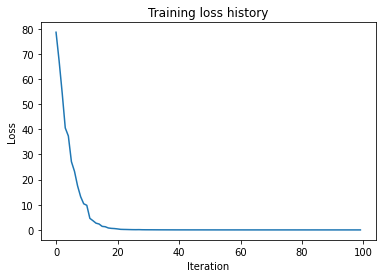

In [93]:
plt.figure(figsize=(6,4))
plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

---
---
# [Part 6] RNN Captioning Testing 
Unlike classification models, image captioning models behave very differently at training time and at test time. 

At training time, we have access to the ground-truth caption, so we feed ground-truth words as input to the RNN at each timestep.

While at test time, we sample from the distribution over the vocabulary at each timestep, and feed the sample as input to the RNN at the next timestep.

Therefore we need to implement slightly different forward pass

---
## 1 - Forward Testing Function

Implement a test-time forward pass for the model, sampling captions for input feature vectors.

At each timestep, we embed the current word, pass it and the previous hidden state to the RNN to get the next hidden state, use the hidden state to get scores for all vocab words, and choose the word with the highest score as the next word. The initial hidden state is computed by applying an affine transform to the input image features, and the initial word is the `<START>` token


You will need to initialize the hidden state of the RNN by applying the learned affine transform to the input image features. The first word that you feed to the RNN should be the `<START>` token; its value is stored in the variable `token_start`. 
    


First, you need to project the input feature. Then, at each timestep you will need to do to:  
 1. Embed the previous word using the learned word embeddings 

 2. Make an `RNN step` using the previous hidden state and the embedded current word to get the next hidden state.
 3. Apply the learned affine transformation to the next hidden state to get scores for all words in the vocabulary                          
 4. Select the word with the `highest score` as the next word, writing it (the word index) to the appropriate slot in the captions variable   
                                                                        
For simplicity, you do not need to stop generating after an `<END>` token is sampled, but you can if you want to.                                 

NOTE: we are still working over minibatches in this function.      

---
#### <font color='red'>**EXERCISE:** </font>

Run a test-time forward pass for the model, sampling captions for input    feature vectors.

In [98]:
def rnn_captioning_test(weights, features, word_to_idx, max_length=30):

    # create special token
    token_null  = word_to_idx['<NULL>']
    token_start = word_to_idx.get('<START>')
    token_end   = word_to_idx.get('<END>')
    
    N = features.shape[0]
    captions = token_null * np.ones((N, max_length), dtype=np.int32)

    # Unpack parameters
    W_proj, b_proj   = weights['W_proj'], weights['b_proj']
    W_embed          = weights['W_embed']
    Wx, Wh, b        = weights['Wx'], weights['Wh'], weights['b']
    W_vocab, b_vocab = weights['W_vocab'], weights['b_vocab']
    
    # (0) project the input image feature into current hidden vector
    # call affine_forward() function with input features, W_proj, and b_proj as the projection weights
    current_h, _ = affine_forward(features, W_proj, b_proj)

    # initialize array to accumulate the generated words
    words = np.zeros(N, dtype=int)
    words.fill(token_start)

    # start generating caption
    for step in range(max_length):
        
        # (1) Embedding the output word for the next iteration
        #     call word_embedding_forward() function with input words and W_embed weight
        word_embed, _ = word_embedding_forward(words, W_embed)
        
        # (2) Make an RNN step using the previous hidden state and the embedded current word to get the next hidden state;
        #     call rnn_step_forward() function with input word_embed and current_h
        #     also pass weights Wx, Wh, and bias b weights into the function
        current_h, _ = rnn_step_forward(word_embed, current_h, Wx, Wh, b)

        # (3) Apply the learned affine transformation to the next hidden state to get scores for all words in the vocabulary 
        #     call affine_forward() function with input current_h, W_vocab and b_vocab
        scores, _ = affine_forward(current_h, W_vocab, b_vocab)

        # (4) Select the word with the highest score as the next word
        #     use np.argmax() to scores with axis=1
        captions[:, step] = np.argmax(scores, axis=1)

        # store the generated caption as input word for the next iteration
        words = captions[:, step]
        
    return captions

---
## 2 - Image Captioning Testing Function

Now define function to load several image and generate the caption

In [99]:
def generate_caption(model, data, split, batch_size):
    print('Generating Caption from ',split,'set images')
    print('-------------------------------------------')
    
    gt_captions, features, urls = sample_coco_minibatch(data, split=split, batch_size=batch_size)
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = rnn_captioning_test(model, features, data['word_to_idx'])
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        fig = plt.figure(figsize=(8,6))
        plt.imshow(image_from_url(url))
        fig.suptitle('Caption Result : %s\nGround Truth   : %s' % (sample_caption, gt_caption), x=0, y=0.96, ha='left', size=15)
        plt.axis('off')
        plt.show()
        print('\n-----------------------------------------------------\n')

    

---
## 3 - Test-time sampling

After you finish the testing function implementations, run the following to sample from your overfitted model on both training and validation data. 



---
### a. Test on Training Set

The samples on training data should be very good; 


Generating Caption from  train set images
-------------------------------------------


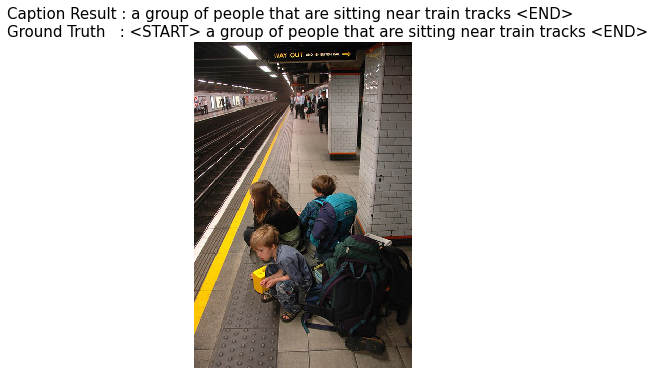


-----------------------------------------------------



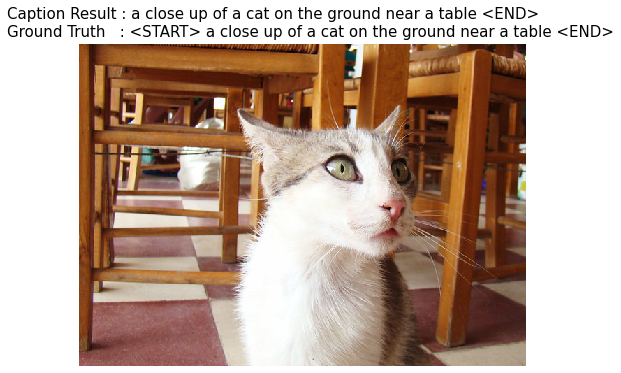


-----------------------------------------------------



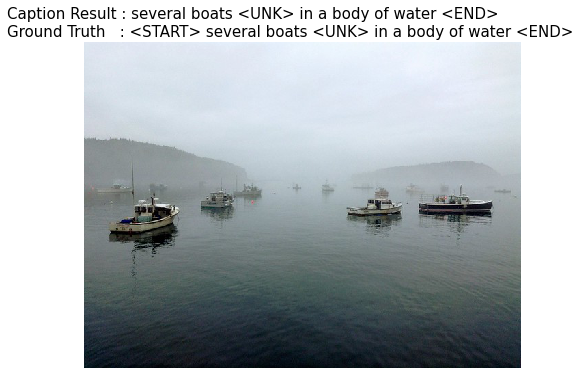


-----------------------------------------------------



In [100]:
generate_caption(model=small_rnn_model, data=small_data, split='train', batch_size=3)

---
### b. Test on Validation  Set
Though, the samples on validation data probably won't make any sense. 
<pre>
    ¯\_(ツ)_/¯ </pre>

Generating Caption from  val set images
-------------------------------------------
URL Error:  Not Found http://farm9.staticflickr.com/8460/8047015886_5c3bd7f289_z.jpg


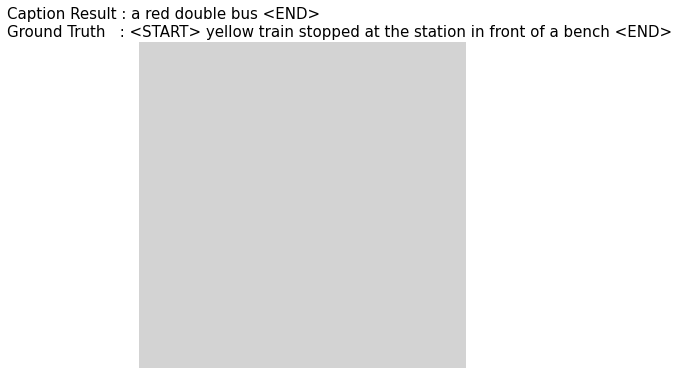


-----------------------------------------------------



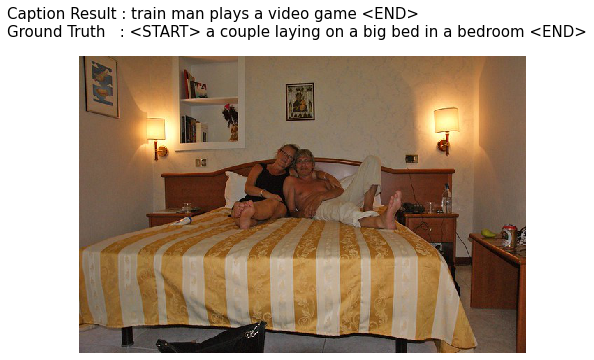


-----------------------------------------------------

URL Error:  Not Found http://farm6.staticflickr.com/5246/5273035490_e6744f7645_z.jpg


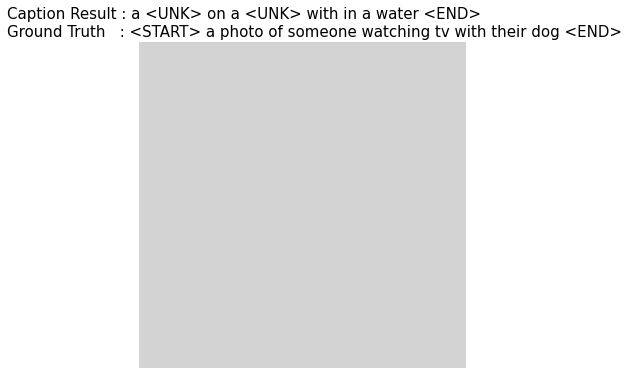


-----------------------------------------------------



In [101]:
generate_caption(model=small_rnn_model, data=small_data, split='val', batch_size=3)


---
---
# [Part 7] Train your own model

* You can continue the training on bigger set of data and test it 
* Or you can change the model to a bigger model

---
## 1 - Get a bigger set of sample data

load a bigger sample set from coco dataset


In [102]:
bigger_data = load_coco_data(max_train=512)

---
## 2 - Generate new and bigger Model
create a new model, (or just use the previous model)


In [103]:
new_model = init_weights(
    word_to_idx = data['word_to_idx'], 
    input_dim   = data['train_features'].shape[1],
    wordvec_dim = 256, 
    hidden_dim  = 512,
)

---
## 3 - Train your model

you can generate new model

you can run this part over-and-over to overfit the data

In [104]:
loss_history, new_model = rnn_captioning_train(
    new_model,
    data         = bigger_data, 
    word_to_idx  = data['word_to_idx'], 
    optimizer    = adam, 
    optim_config = {'learning_rate': 5e-3,},
    epochs       = 100,
    batch_size   = 128,
    lr_decay     = 0.9,
    print_every  = 20,
)

iteration 20 (epoch 4 / 100 ): loss = 37.78306971127332
iteration 40 (epoch 9 / 100 ): loss = 19.75475144185625
iteration 60 (epoch 14 / 100 ): loss = 9.889365674024528
iteration 80 (epoch 19 / 100 ): loss = 5.584803486163528
iteration 100 (epoch 24 / 100 ): loss = 4.259016237615549
iteration 120 (epoch 29 / 100 ): loss = 3.215123052397349
iteration 140 (epoch 34 / 100 ): loss = 2.6873867478394144
iteration 160 (epoch 39 / 100 ): loss = 2.6551562329181744
iteration 180 (epoch 44 / 100 ): loss = 2.95585091422729
iteration 200 (epoch 49 / 100 ): loss = 2.427392834747353
iteration 220 (epoch 54 / 100 ): loss = 2.6539685872496355
iteration 240 (epoch 59 / 100 ): loss = 2.6171519892194848
iteration 260 (epoch 64 / 100 ): loss = 2.590684299908265
iteration 280 (epoch 69 / 100 ): loss = 2.4497274315809086
iteration 300 (epoch 74 / 100 ): loss = 2.5056027718875233
iteration 320 (epoch 79 / 100 ): loss = 2.3735900382212987
iteration 340 (epoch 84 / 100 ): loss = 2.420696146783926
iteration 360 

**EXPECTED OUTPUT**:
<pre>
    loss shoud start around 37 and end around 1.7

Plot the training losses

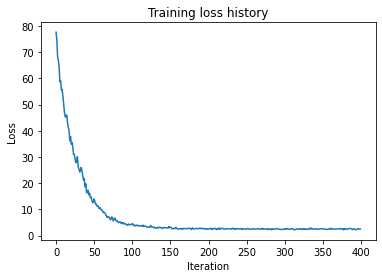

In [105]:
plt.figure(figsize=(6,4))
plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

---
## 4 - Test the trained model

Now test it

---
### a. Test on Training Set

The samples on training data should be very good; 


Generating Caption from  train set images
-------------------------------------------


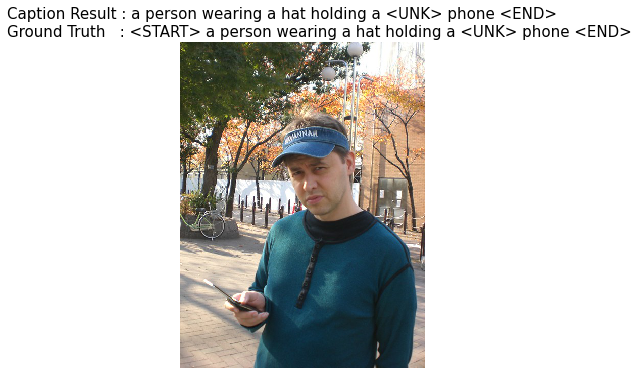


-----------------------------------------------------



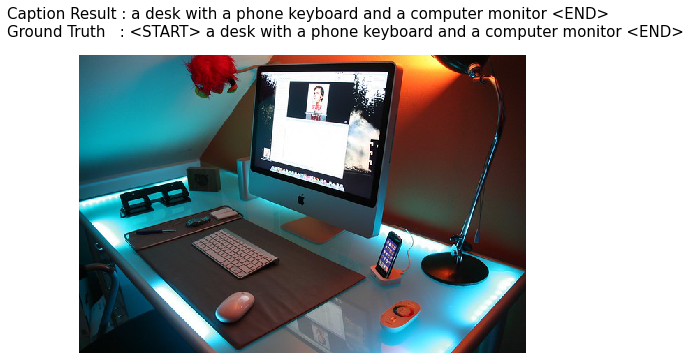


-----------------------------------------------------

URL Error:  Not Found http://farm7.staticflickr.com/6035/5915552004_04ae855262_z.jpg


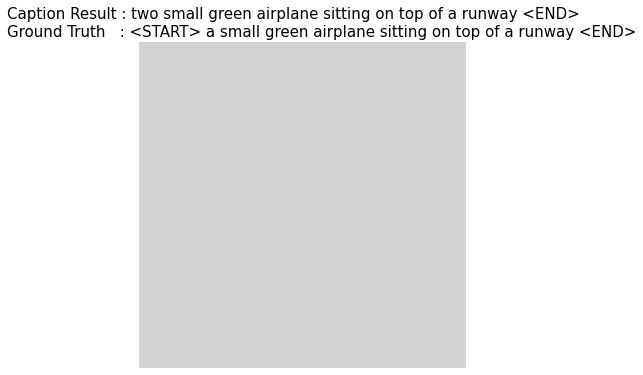


-----------------------------------------------------



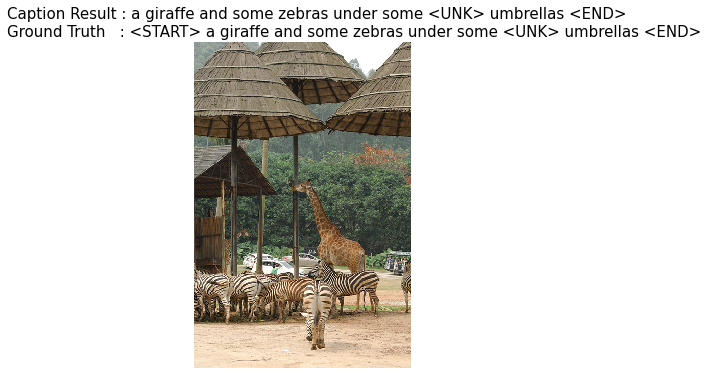


-----------------------------------------------------



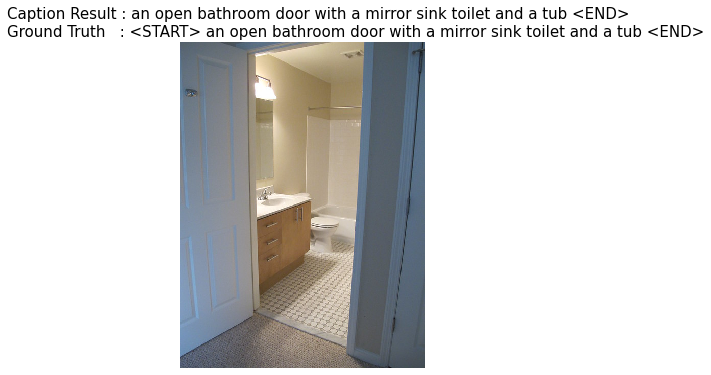


-----------------------------------------------------



In [106]:
generate_caption(model=new_model, data=bigger_data, split='train', batch_size=5)

after several training step, you should see that the validation captioning is getting better

---
### b. Test on Validation  Set
You should see that some of the captions are starting to get it right



Generating Caption from  val set images
-------------------------------------------


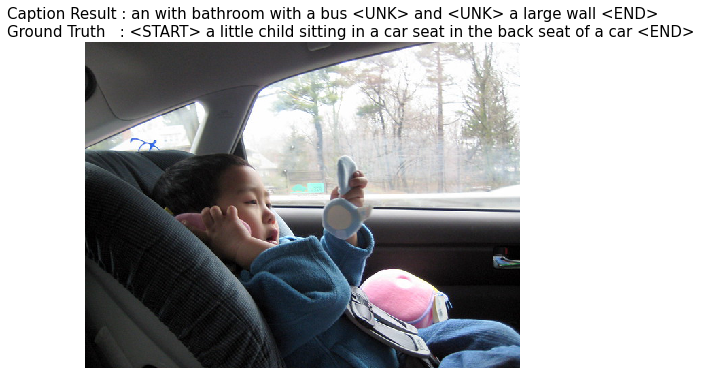


-----------------------------------------------------



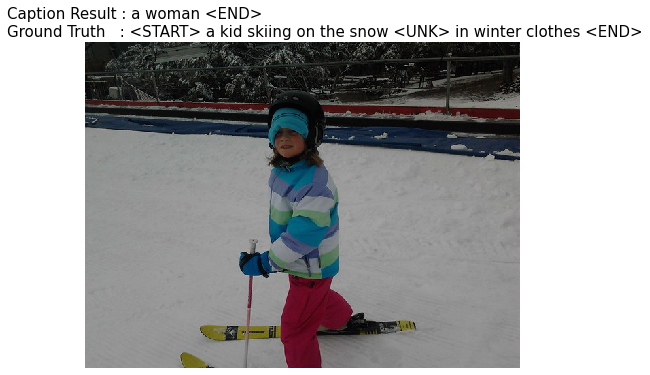


-----------------------------------------------------



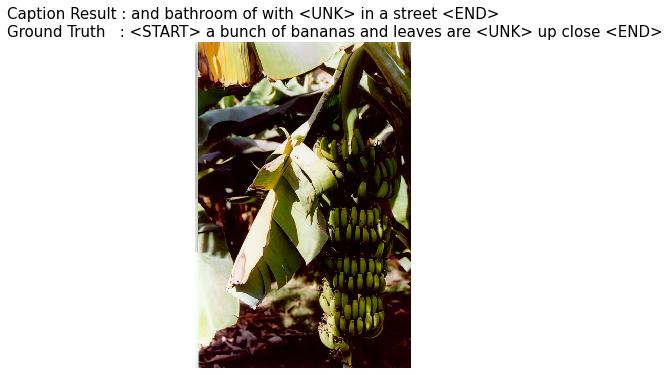


-----------------------------------------------------



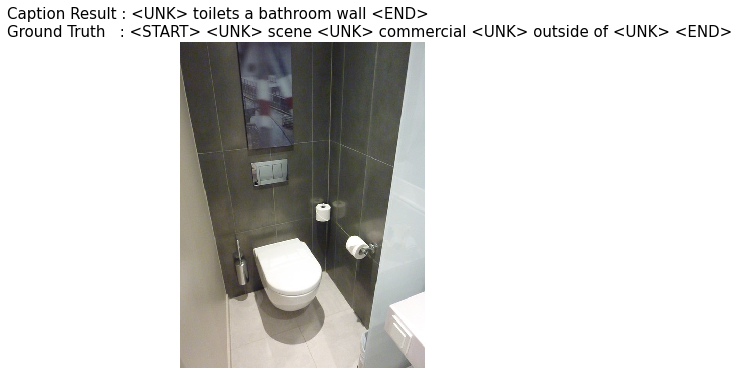


-----------------------------------------------------



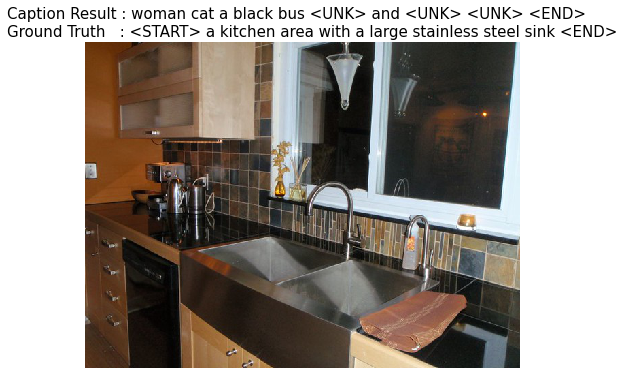


-----------------------------------------------------



In [107]:
generate_caption(model=new_model, data=bigger_data, split='val', batch_size=5)


You can train it more to increase the performance


---

# Congratulation, You've Completed Exercise 17
<p>Copyright &copy;  <a href=https://www.linkedin.com/in/andityaarifianto/>2020 - ADF</a> </p>

![footer](https://i.ibb.co/yX0jfMS/footer2020.png)